# Mapping migration

Introduction to vector data operations

## STEP 0: Set up

To get started on this notebook, you’ll need to restore any variables
from previous notebooks to your workspace. To save time and memory, make
sure to specify which variables you want to load.

In [12]:
%store -r
import os
import pathlib 
from pathlib import Path
import urllib.request, zipfile
import matplotlib.pyplot as plt

import earthpy as et
import earthpy.io as eio
import geopandas as gpd
import pandas as pd


## STEP 1: Create a directory for your data

For this challenge, you will need to download some data to the computer
you’re working on. We suggest using the `earthpy` library we develop to
manage your downloads, since it encapsulates many best practices as far
as:

1.  Where to store your data
2.  Dealing with archived data like .zip files
3.  Avoiding version control problems
4.  Making sure your code works cross-platform
5.  Avoiding duplicate downloads

If you’re working on one of our assignments through GitHub Classroom, it
also lets us build in some handy defaults so that you can see your data
files while you work.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Create a project folder</div></div><div class="callout-body-container callout-body"><p>The code below will help you get started with making a project
directory</p>
<ol type="1">
<li>Replace <code>project_title</code> with the actual project title,
Veery Migration 2023</li>
<li>Replace <code>'your-project-directory-name-here'</code> with a
<strong>descriptive</strong> name</li>
<li>The code should have printed out the path to your data files. Check
that your data directory exists and has data in it using the terminal or
your Finder/File Explorer.</li>
</ol></div></div>

> **File structure**
>
> These days, a lot of people find your file by searching for them or
> selecting from a `Bookmarks` or `Recents` list. Even if you don’t use
> it, your computer also keeps files in a **tree** structure of folders.
> Put another way, you can organize and find files by travelling along a
> unique **path**, e.g. `My Drive` \> `Documents` \>
> `My awesome project` \> `A project file` where each subsequent folder
> is **inside** the previous one. This is convenient because all the
> files for a project can be in the same place, and both people and
> computers can rapidly locate files they want, provided they remember
> the path.
>
> You may notice that when Python prints out a file path like this, the
> folder names are **separated** by a `/` or `\` (depending on your
> operating system). This character is called the **file separator**,
> and it tells you that the next piece of the path is **inside** the
> previous one.

In [13]:
# Create data directory - alternative method because original method in notebook did not work (commented out below)
desktop = Path.home() / "Desktop"

# Put the project on your Desktop
base_dir = desktop / "earth-analytics"
project_dir = base_dir / "VeeryMigration" / "MigrationData"   
project_dir.mkdir(parents=True, exist_ok=True)

print("Project directory created at:", project_dir.resolve())

# Original network code - replaced with above
# project = earthpy.Project(
#    title=VeeryMigration25,
#    dirname='MigrationData')
# Download sample data
# project.get_data()

# Display the project directory
# project.project_dir

Project directory created at: C:\Users\seism\Desktop\earth-analytics\VeeryMigration\MigrationData


In [14]:
# Get data - broken out from above
# Where to save (Desktop → earth-analytics/VeeryMigration/MigrationData)
dest = (Path.home() / "Desktop" / "earth-analytics" / "VeeryMigration" / "MigrationData")
dest.mkdir(parents=True, exist_ok=True)

csv_url = "https://figshare.com/ndownloader/files/58363291"      # GBIF observation data
zip_url = "https://storage.googleapis.com/teow2016/Ecoregions2017.zip"   # ecoregion data

# Download CSV
csv_path = dest / Path(csv_url).name
urllib.request.urlretrieve(csv_url, csv_path)
print("Saved CSV →", csv_path)

# Download ZIP
zip_path = dest / Path(zip_url).name
urllib.request.urlretrieve(zip_url, zip_path)
print("Saved ZIP →", zip_path)

# Unzip (optional)
with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(dest)
print("Unzipped →", dest)

Saved CSV → C:\Users\seism\Desktop\earth-analytics\VeeryMigration\MigrationData\58363291
Saved ZIP → C:\Users\seism\Desktop\earth-analytics\VeeryMigration\MigrationData\Ecoregions2017.zip
Unzipped → C:\Users\seism\Desktop\earth-analytics\VeeryMigration\MigrationData


## STEP 2: Define your study area – the ecoregions of North America

Your sample data package included a Shapefile of global **ecoregions**.
You should be able to see changes in the number of observations of Veery
thrush in each ecoregion throughout the year.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-info"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div></div><div class="callout-body-container callout-body"><p>You don’t have to use ecoregions to group species observations – you
could choose to use political boundaries like countries or states, other
natural boundaries like watersheds, or even uniform hexagonal areas as
is common in conservation work. We chose ecoregions because we expect
the suitability for a species at a particular time of year to be
relatively consistent across the region.</p></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-read"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Read More</div></div><div class="callout-body-container callout-body"><p>The ecoregion data will be available as a <strong>shapefile</strong>.
Learn more about shapefiles and vector data in this <a
href="https://www.earthdatascience.org/courses/intro-to-earth-data-science/file-formats/use-spatial-data/use-vector-data/">Introduction
to Spatial Vector Data File Formats in Open Source Python</a></p></div></div>

### Load the ecoregions into Python

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Load ecoregions into Python</div></div><div class="callout-body-container callout-body"><p>Download and save ecoregion boundaries from the EPA:</p>
<ol type="1">
<li>Replace <code>a_path</code> with the path your created for your
ecoregions file.</li>
<li>Make a quick plot with <code>.plot()</code> to make sure the
download worked.</li>
</ol></div></div>

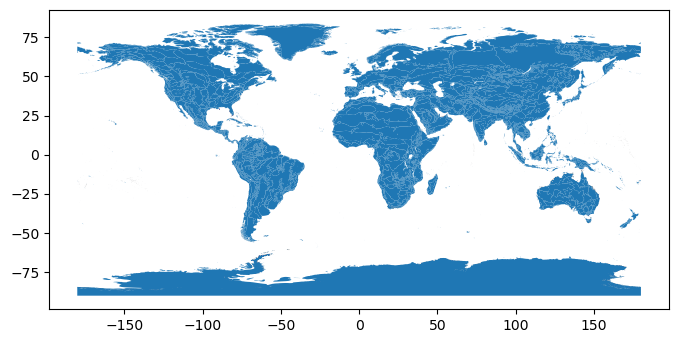

In [15]:
# Actual shapefile path (after unzipping the ecoregions ZIP)
a_path = Path.home() / "Desktop" / "earth-analytics" / "VeeryMigration" / "MigrationData" / "Ecoregions2017.shp"

# Open up the ecoregions boundaries
ecoregions_gdf = gpd.read_file(a_path)

# Plot the ecoregions quickly to check download
ecoregions_gdf.plot(figsize=(8,6))
plt.show()

## STEP 3: Load species observation data

For this challenge, you will use a database called the [Global
Biodiversity Information Facility (GBIF)](https://www.gbif.org/). GBIF
is compiled from species observation data all over the world, and
includes everything from museum specimens to photos taken by citizen
scientists in their backyards. We’ve compiled some sample data in the
same format that you will get from GBIF.

Let’s start by looking at a little of the raw data.

In [16]:
gbif_path = project_dir / "58363291"
print("CSV path", gbif_path)

CSV path C:\Users\seism\Desktop\earth-analytics\VeeryMigration\MigrationData\58363291


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Load GBIF data</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Look at the beginning of the file you downloaded using the code
below. What do you think the <strong>delimiter</strong> is?</li>
<li>Run the following code cell. What happens?</li>
<li>Uncomment and modify the parameters of <code>pd.read_csv()</code>
below until your data loads successfully and you have only the columns
you want.</li>
</ol></div></div>

You can use the following code to look at the beginning of your file:

In [17]:
# I am on a Windows machine, so I couldn't use this command (at least that was what google told me)
# !head -n 2 $gbif_path 

# A windows friendly way to look at the beginning of the file
# preview first 2 raw lines
with open(gbif_path, "r", encoding="utf-8", errors="replace") as f:
    for _ in range(2):
        print(f.readline().rstrip("\n"))

gbifID	datasetKey	occurrenceID	kingdom	phylum	class	order	family	genus	species	infraspecificEpithet	taxonRank	scientificName	verbatimScientificName	verbatimScientificNameAuthorship	countryCode	locality	stateProvince	occurrenceStatus	individualCount	publishingOrgKey	decimalLatitude	decimalLongitude	coordinateUncertaintyInMeters	coordinatePrecision	elevation	elevationAccuracy	depth	depthAccuracy	eventDate	day	month	year	taxonKey	speciesKey	basisOfRecord	institutionCode	collectionCode	catalogNumber	recordNumber	identifiedBy	dateIdentified	license	rightsHolder	recordedBy	typeStatus	establishmentMeans	lastInterpreted	mediaType	issue
4158712344	8a863029-f435-446a-821e-275f4f641165	https://observation.org/observation/273993634	Animalia	Chordata	Aves	Passeriformes	Turdidae	Catharus	Catharus fuscescens		SPECIES	Catharus fuscescens (Stephens, 1817)	Catharus fuscescens		CA	Ontario - Point Pelee NP	Ontario	PRESENT	1	c8d737e0-2ff8-42e8-b8fc-6b805d26fc5f	41.9137	-82.5092	8.0						2023-05-19	19	5	202

In [18]:
# Load the GBIF data
gbif_df = pd.read_csv(
    gbif_path, 
    delimiter='\t',
    usecols=["gbifID","decimalLatitude","decimalLongitude","month"]
)
gbif_df.head()

,gbifID,decimalLatitude,decimalLongitude,month
0,4158712344,41.913700,-82.509200,5
1,4923515059,41.852812,-87.611721,5
2,4923522410,41.852812,-87.611721,9
3,4923520798,41.852812,-87.611721,5
4,4923520314,41.880356,-87.630134,9


### Convert the GBIF data to a GeoDataFrame

To plot the GBIF data, we need to convert it to a `GeoDataFrame` first.
This will make some special geospatial operations from `geopandas`
available, such as spatial joins and plotting.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Convert `DataFrame` to `GeoDataFrame`</div></div><div class="callout-body-container callout-body"><ol type="1">
<li>Replace <code>your_dataframe</code> with the name of the
<code>DataFrame</code> you just got from GBIF</li>
<li>Replace <code>longitude_column_name</code> and
<code>latitude_column_name</code> with column names from your
`DataFrame</li>
<li>Run the code to get a <code>GeoDataFrame</code> of the GBIF
data.</li>
</ol></div></div>

In [19]:
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_df, 
        geometry=gpd.points_from_xy(
            gbif_df["decimalLongitude"], gbif_df["decimalLatitude"]), 
        crs="EPSG:4326")
    # Select the desired columns
    [["gbifID","month","geometry"]]
)
gbif_gdf

,gbifID,month,geometry
0,4158712344,5,POINT (-82.5092 41.9137)
1,4923515059,5,POINT (-87.61172 41.85281)
2,4923522410,9,POINT (-87.61172 41.85281)
3,4923520798,5,POINT (-87.61172 41.85281)
4,4923520314,9,POINT (-87.63013 41.88036)
...,...,...,...
165609,4423534780,9,POINT (-75.1254 40.0626)
165610,4524632357,6,POINT (-89.8049 44.6967)
165611,4173211734,5,POINT (-82.4753 42.0478)
165612,4173216429,6,POINT (-74.5468 46.1638)


<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It</div></div><div class="callout-body-container callout-body"><p>Make sure to store the new version of your <code>DataFrame</code> for
other notebooks!</p>
<div id="f1412915" class="cell" data-execution_count="14">
<div class="sourceCode" id="cb1"><pre
class="sourceCode python cell-code"><code class="sourceCode python"><span id="cb1-1"><a href="#cb1-1" aria-hidden="true" tabindex="-1"></a><span class="op">%</span>store ecoregions_gdf gbif_gdf</span></code></pre></div>
</div></div></div>

# STEP -1: Wrap up

Don’t forget to store your variables so you can use them in other
notebooks! Replace `var1` and `var2` with the variable you want to save,
separated by spaces.

In [20]:
%store gbif_gdf ecoregions_gdf

Stored 'gbif_gdf' (GeoDataFrame)
Stored 'ecoregions_gdf' (GeoDataFrame)


Finally, be sure to `Restart` and `Run all` to make sure your notebook
works all the way through!